# Airbnb Data Analysis

Data from [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

## Data Preparation
1. Prepare data set for each city
2. Clean data for each city

In [1]:
# need to install this package first
# install.packages("stringi")

In [2]:
library(dplyr)
# issue with this one
library(stringr)
library(ggplot2)
library(data.table)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [3]:
# Function from the data_prep script

# a generic function to prepare data for a specific city, data_date
prepare_data <- function(city, data_date)
{
    # Cleaning listings dataframe
    
    # suppose raw data is stored in data_raw/city/data_date/listings.csv.gz
    listings_url <- file.path("data_raw", city, data_date, "listings.csv.gz")
    # suppose raw data is stored in data_raw/city/data_date/calendar.csv.gz
    calendar_url <- file.path("data_raw", city, data_date, "calendar.csv.gz")
    
    print(paste0("reading data from ", listings_url))
    listings <- read.csv(gzfile(listings_url))
    print(paste0("reading data from ", calendar_url))
    calendar <- read.csv(gzfile(calendar_url))
    
    ## Add Keys: columns city and day date
    listings$city <- city
    listings$data_date <- data_date
    
    ## Select interesting columns
    ### Most columns don't contain interesting information
    columns_listings <- c("city", "data_date", "id", "neighbourhood_cleansed", 
                          "latitude", "longitude", 
                          "property_type", "room_type", "accommodates", "bedrooms", 
                          "beds", "price", "minimum_nights",  "maximum_nights")
    
    listings <- listings %>% 
        select(columns_listings) %>% 
        arrange(id)
    
    
    # Cleaning calendar dataframe
    
    ## arrange by id and date
    calendar <- calendar %>% 
        arrange(listing_id, date)
    
    ## add day number (starting first day)
    calendar <- calendar %>%
        group_by(listing_id) %>%
        mutate(day_nb = row_number()) %>%
        ungroup()
    
    ## change available column to binary
    calendar <- calendar %>%
        mutate(available = ifelse(available=="t", 1, 0))
    
    ## clean price column and transform to numeric
    calendar <- calendar %>%
        mutate(price = str_replace(price, "\\$", ""),
               adjusted_price = str_replace(adjusted_price, "\\$", ""))
    calendar <- calendar %>%
        mutate(price = str_replace(price, ",", ""),
               adjusted_price = str_replace(adjusted_price, ",", ""))
    calendar <- calendar %>%
        mutate(price = as.numeric(price),
               adjusted_price = as.numeric(adjusted_price))
    
    ## calculate estimated revenue for upcoming day
    calendar <- calendar %>%
        mutate(revenue = price*(1-available))
    
    ## calculate availability, price, revenue for next 30, 60 days ... for each listing_id
    calendar <- calendar %>%
        group_by(listing_id) %>%
        summarise(availability_30 = sum(available[day_nb<=30], na.rm = TRUE),
                  availability_60 = sum(available[day_nb<=60], na.rm = TRUE),
                  availability_90 = sum(available[day_nb<=90], na.rm = TRUE),
                  availability_365 = sum(available[day_nb<=365], na.rm = TRUE),
                  price_30 = mean(price[day_nb<=30 & available==0], na.rm = TRUE),
                  price_60 = mean(price[day_nb<=60 & available==0], na.rm = TRUE),
                  price_90 = mean(price[day_nb<=90 & available==0], na.rm = TRUE),
                  price_365 = mean(price[day_nb<=365 & available==0], na.rm = TRUE),
                  revenue_30 = sum(revenue[day_nb<=30], na.rm = TRUE),
                  revenue_60 = sum(revenue[day_nb<=60], na.rm = TRUE),
                  revenue_90 = sum(revenue[day_nb<=90], na.rm = TRUE),
                  revenue_365 = sum(revenue[day_nb<=365], na.rm = TRUE)           
        )
    
    listings_cleansed <- listings %>% left_join(calendar, by = c("id" = "listing_id"))
    
    dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE)
    
    write.csv(listings_cleansed, file.path("data_cleansed", city, data_date, "listings.csv"))
    print(paste0("saving data into ", file.path("data_cleansed", city, data_date, "listings.csv")))
    
}  

### Unit test : Reading data for malaga:
#### Preparing data, working ✅

In [4]:
# city <- "malaga"
# data_date <- "2020-06-30"
# prepare_data(city,data_date)

# Prepare data for all selected cities 

In [12]:
# Reading cleansed data
cities <- c("malaga", "mallorca", "sevilla")
data_dates <- c("2020-06-30", "2020-09-19", "2020-06-29")

# We are only interested in data between min_date and max_date
min_date <- '2020-05-01'
max_date <- '2020-11-01'

files_paths <- c()

### Preparare data for Malaga, mallorca, sevilla

In [6]:
for(i in 1:length(cities)){
    city <- cities[i]
    data_date <- data_dates[i]
    print("-------------------------------------------------")
    print(paste(c("Preparing data for", city, "compiled at", data_date), collapse = " "))
    prepare_data(city, data_date)
}

# Clean Environment
rm(list=ls())

[1] "-------------------------------------------------"
[1] "Preparing data for malaga compiled at 2020-06-30"
[1] "reading data from data_raw/malaga/2020-06-30/listings.csv.gz"
[1] "reading data from data_raw/malaga/2020-06-30/calendar.csv.gz"


Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
“'data_cleansed/malaga/2020-06-30' already exists”

[1] "saving data into data_cleansed/malaga/2020-06-30/listings.csv"
[1] "-------------------------------------------------"
[1] "Preparing data for mallorca compiled at 2020-09-19"
[1] "reading data from data_raw/mallorca/2020-09-19/listings.csv.gz"
[1] "reading data from data_raw/mallorca/2020-09-19/calendar.csv.gz"


Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
“'data_cleansed/mallorca/2020-09-19' already exists”

[1] "saving data into data_cleansed/mallorca/2020-09-19/listings.csv"
[1] "-------------------------------------------------"
[1] "Preparing data for sevilla compiled at 2020-06-29"
[1] "reading data from data_raw/sevilla/2020-06-29/listings.csv.gz"
[1] "reading data from data_raw/sevilla/2020-06-29/calendar.csv.gz"


Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
“'data_cleansed/sevilla/2020-06-29' already exists”

[1] "saving data into data_cleansed/sevilla/2020-06-29/listings.csv"


### Read data in cities between min_date and max_date

In [13]:
for(city in cities){
    file_dir <- file.path(".", "data_cleansed", city)
    file_subdirs <- list.dirs(file_dir)
    file_subdirs <- file_subdirs[-1]

    for(file_subdir in file_subdirs){
        if(file_subdir < file.path(file_dir, min_date) | file_subdir > file.path(file_dir, max_date)  )
            file_subdirs = file_subdirs[file_subdirs != file_subdir]
    }
    files_paths <- c(files_paths, file_subdirs)
}
files_paths <- file.path(files_paths, "listings.csv")
listings <- 
    do.call(rbind,
            lapply(files_paths, read.csv, row.names=1))

In [15]:
summary(listings)

       city            data_date           id          
 malaga  : 6301   2020-06-30: 6301   Min.   :   11547  
 mallorca:17608   2020-09-19:17608   1st Qu.:17278276  
 sevilla : 6668   2020-06-29: 6668   Median :26547472  
                                     Mean   :26203204  
                                     3rd Qu.:37310559  
                                     Max.   :45499210  
                                                       
       neighbourhood_cleansed    latitude       longitude      
 Centro           : 4327      Min.   :36.64   Min.   :-6.0165  
 Pollença         : 2268      1st Qu.:37.39   1st Qu.:-4.4354  
 Palma de Mallorca: 1952      Median :39.43   Median : 2.6531  
 Alcúdia          : 1732      Mean   :38.56   Mean   :-0.4932  
 Manacor          :  902      3rd Qu.:39.71   3rd Qu.: 3.0743  
 Santanyí         :  887      Max.   :39.93   Max.   : 3.4755  
 (Other)          :18509                                       
          property_type             room

### Preprocessing 

In [16]:
listings$bedrooms <- ifelse(listings$bedrooms >= 5, "5+", listings$bedrooms)

# to do : break even point
# steps 1 : find the average price for the squarre meter in the city --> fixed costs 
# steps 2 : find the average price for the electricity and gas for --> variable costs 
# steps 3 : compute the break even point in day

In [20]:
names(listings)

[1] "city"                   "data_date"              "id"                    
 [4] "neighbourhood_cleansed" "latitude"               "longitude"             
 [7] "property_type"          "room_type"              "accommodates"          
[10] "bedrooms"               "beds"                   "price"                 
[13] "minimum_nights"         "maximum_nights"         "availability_30"       
[16] "availability_60"        "availability_90"        "availability_365"      
[19] "price_30"               "price_60"               "price_90"              
[22] "price_365"              "revenue_30"             "revenue_60"            
[25] "revenue_90"             "revenue_365"

## Example of analysis

Warning message:
“Removed 3058 rows containing non-finite values (stat_boxplot).”

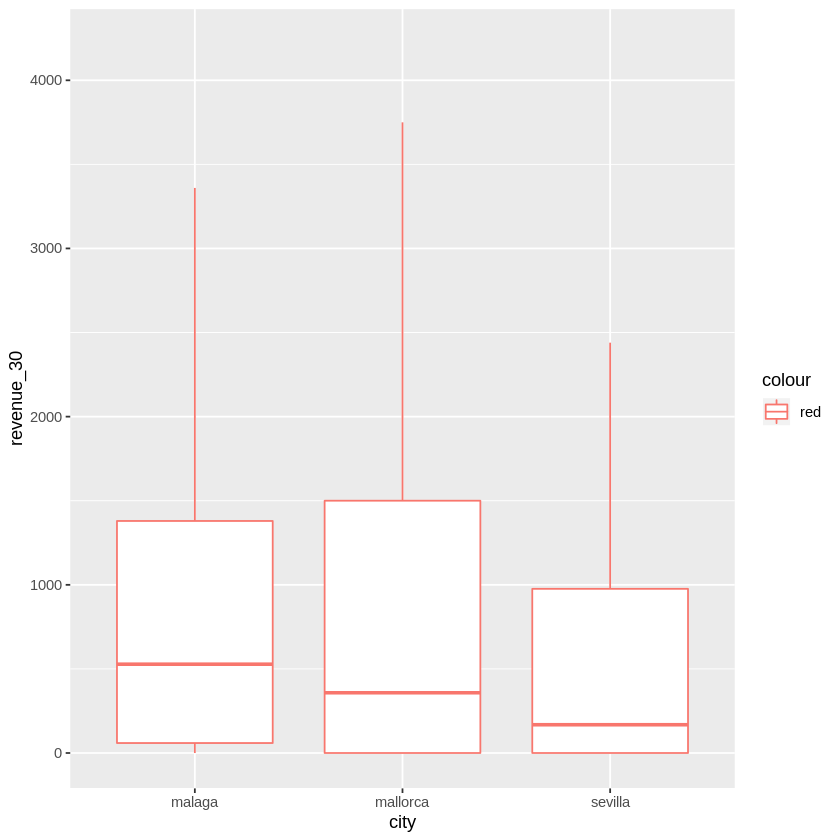

In [21]:
# Analysis 1
## Comparing the distribution of estimated revenue for the next 30 days of listings
## per each city.
p <- ggplot(listings, aes(city, revenue_30))
p + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T))

## Analysis : comparing cities

#### 1. Find the "average availability over 30 days" of listings per each city

In [30]:
dim(listings$availability_30)

[1] 30577    26

In [22]:
apply(listings$availability_30, 2, mean)

ERROR: Error in apply(listings$availability_30, 2, mean): dim(X) must have a positive length
